# Imports


In [ ]:
# import files and required classes
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import argparse

# for data visualization
import matplotlib.pyplot as plt 
!pip install visdom
import visdom
!pip install trimesh
import trimesh

from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('content/drive/My Drive/Shared_With_Me/Qmind_Object_Completion_Team/TreeGAN')

     |████████████████████████████████| 686kB 7.9MB/s 
     |████████████████████████████████| 204kB 18.2MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp37-none-any.whl size=655251 sha256=e6abb8ab1f17d3b508d867f20a1183372ba276378b8cd377fe925a3ca59fa7b1
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5713 sha256=93980b25191951c661dbdd6cb7a72500f50eb9da7b7c4a37dea8bb735454ab1c
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile
     |████████████████████████████████| 634kB 8.6MB/s 
Mounted at /content/drive/


# Arguments Class

In [ ]:
class Arguments:
  def __init__(self):
    self._parser = argparse.ArgumentParser(description='Arguments for TreeGAN.')

    # Datatset arguements
    self._parser.add_argument('--batch_size', type=int, default=20, help='Integer value for batch size.')
    self._parser.add_argument('--point_num', type=int, default=2048, help='Integer value for number of points.')
    self._parser.add_argument('--latent_dim', type=int, default=96, help='Integer value for latent vector dimension')
    # Training arguments
    self._parser.add_argument('--epochs', type=int, default=2000, help='Integer value for epochs')
    self._parser.add_argument('--lr', type=float, default=1e-4, help='Float value for learning rate')
    # Add checkpoint saving arguments
    self._parser.add_argument('--save_rate', type=int, default=10, help='Model is saved every epoch multiple of this value')
    self._parser.add_argument('--save_d_ckpt', type=str, default='save_checkpoint_path', help='Save location for checkpoints') # Discriminator save checkpoint path
    self._parser.add_argument('--load_d_ckpt', type=str, default='load_checkpoint_path', help='Load location for checkpoints') # Discriminator load checkpoint path
    self._parser.add_argument('--save_g_ckpt', type=str, default='save_checkpoint_path', help='Save location for checkpoints') # Generator save checkpoint path
    self._parser.add_argument('--load_g_ckpt', type=str, default='load_checkpoint_path', help='Load location for checkpoints') # Generator load checkpoint path

    #visualization args
    self._parser.add_argument('--visdom_port', type=int, default=8097, help='Visdom port number. (default:8097)')
    self._parser.add_argument('--visdom_color', type=int, default=4, help='Number of colors for visdom pointcloud visualization. (default:4)')  
    
    #Network arguments
    self._parser.add_argument('--lamdaGP', type=int, default=10, help='Lambda for GP term')
    self._parser.add_argument('--D_iter', type=int, default=5, help='Number of training iterations for discriminator')
    self._parser.add_argument('--support', type=int, default=10, help='Support term value for TreeGCN loop term')
    self._parser.add_argument('--DEGREE', type=int, default=[1, 2, 2, 2, 2, 2, 64], nargs='+', help='Upsample degrees for generator')
    self._parser.add_argument('--G_FEAT', type=int, default=[96, 256, 256, 256, 128, 128, 128, 3], nargs='+', help='Features for generator')
    self._parser.add_argument('--D_FEAT', type=int, default=[3, 64, 128, 256, 512, 1024], nargs='+', help='Features for discriminator')

  def parser(self):
    return self._parser

# TreeGCN Model

In [ ]:
class TreeGCN(keras.layers.Layer):
  def __init__(self, batch, depth, features, degrees, support=10, node=1, upsample=False, activation=True, kernel_initializer='glorot_uniform'):
    self.batch = batch
    self.depth = depth
    self.in_feature = features[depth]
    self.out_feature = features[depth+1]
    self.node = node
    self.degree = degrees[depth]
    self.upsample = upsample
    self.activation = activation 
    super(TreeGCN, self).__init__()

    #Need to create a list of submodules similar to nn.ModuleList
    #This is certainly creating an accessible array of layers, not sure if it has the same dependencies
    self.W_root = Sequential()
    # self.W_root = [Dense(self.out_features, input_dim=features[index], use_bias=False) for index in range(self.depth + 1)]
    for index in range(self.depth + 1):
      self.W_root.add(Dense(self.out_features, input_dim=features[index], use_bias=False))

    
    #Declare the loop, which has two linear layers (Dense in keras) with no bias and this input shape
    self.W_loop = Sequential()
    self.W_loop.add(Dense(self.in_feature*support, input_dim=self.in_feature, use_bias=False))
    self.W_loop.add(Dense(self.out_feature , use_bias=False)) 

    def build_branch(self):
      if self.upsample:
        kernel_initializer = tf.keras.initializer.glorot_uniform()
        self.branch_input_shape = (self.node, self.in_feature, self.in_feature * self.degree)
        self.W_branch = self.add_weight(name = 'branch',
                    shape=self.branch_input_shape,
                    initializer= kernel_initializer,
                    trainable= True)

      stdv =  1. / math.sqrt(self.out_feature)
      bias_initializer = tf.keras.initializer.RandomUniform(minval=-stdv, maxval=stdv)
      self.bias = self.add_weight(name= 'bias',
                   shape= (1, self.degree, self.out_feature),
                   initializer= bias_initializer,
                   trainable=True) 
      # gain -> relu used here in original code


    self.leaky_relu = LeakyRelu(alpha=0.2)
    self.build_branch()

    def call(self, tree):
      root = 0
      
      for inx in range(self.depth+1):
        root_num = tree[inx].shape[1] # obtains number of roots in layer
        repeat_num = int(self.node / root_num) # all nodes / nodes in curr tree
        root_node = self.W_root[inx](tree[inx]) # applies tree at inx into layer inx and returns matrix of size: out_features * (depth + 1)
        temp = np.tile(root_node,(1,1, repeat_num,)).reshape((self.batch, -1, self.out_feature,))
        root = root + temp

      branch = 0
      if self.upsample:
        branch = np.expand_dims(tree[-1], axis=2) @ self.W_branch # not sure what W_branch is doing
        branch = self.leaky_relu(branch)
        branch = branch.reshape(self.batch, self.node*self.degree, self.in_feature)

        branch = self.W_loop(branch)
        branch = np.tile(root,(1,1, self.degree,)).reshape((self.batch, -1, self.out_feature,)) + branch
      else:
        branch = self.W_loop(tree[-1])
        branch = root + branch

      if self.activation:
        branch = self.leaky_relu(branch + np.tile(self.bias, (1, self.node, 1,)))
      tree.append(branch)

      return tree

# Generator Model

In [ ]:
class Generator(keras.layers.Layer):
    def __init__(self, batch_size, features, degrees, support):
        self.batch_size = batch_size
        self.layer_num = len(features)-1
        assert self.layer_num == len(degrees), "Number of features should be one more than number of degrees."
        self.pointcloud = None
        super(Generator, self).__init__()
                
        vertex_num = 1
        self.gcn = Sequential()
        for inx in range(self.layer_num):
            if inx == self.layer_num-1:
                self.gcn.add('TreeGCN_'+str(inx),
                                    TreeGCN(self.batch_size, inx, features, degrees, 
                                            support=support, node=vertex_num, upsample=True, activation=False))
            else:
                self.gcn.add('TreeGCN_'+str(inx),
                                    TreeGCN(self.batch_size, inx, features, degrees, 
                                            support=support, node=vertex_num, upsample=True, activation=True))
            vertex_num = int(vertex_num * degrees[inx])

    def forward(self, tree):
        feat = self.gcn(tree)
        
        self.pointcloud = feat[-1]

        return self.pointcloud

    def getPointcloud(self):
        return self.pointcloud[-1]

# Discriminator Model

In [ ]:
# TODO(Noah): Can play around with the discriminator architecture
class Discriminator(tf.keras.Model):
    
    def __init__(self, batch_size, features):
        
        self.batch_size = batch_size
        self.layer_num = len(features)-1
        super(Discriminator, self).__init__()
        
        self.fc_layers = []
        for inx in range(self.layer_num):
            self.fc_layers.append(tf.keras.layers.Conv1D( filters=features[inx+1], kernel_size=1, strides=1 ))
            
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
    
        self.final_layer = keras.Sequential()
        self.final_layer.add(tf.keras.layers.Dense(features[-1]))
        self.final_layer.add(tf.keras.layers.Dense(features[-2]))
        self.final_layer.add(tf.keras.layers.Dense(features[-2]))
        self.final_layer.add(tf.keras.layers.Dense(1))
      
    def call(self, inputs, training=False):
        # inputs is a batch of tensors, so the expected shape should be something like (, 3072, 3) 

        feat = tf.transpose(inputs, perm=[0, 2, 1]) 
        #print("feat.shape", feat.shape)
                
        vertex_dim = feat.shape[2]
        print("vertex_dim", vertex_dim)

        #vertex_num = feat.size(2) # NOT SURE IF THIS WORKS

        for inx in range(self.layer_num):
            feat = self.fc_layers[inx](feat)
            feat = self.leaky_relu(feat)

        #print("feat.shape after fc_layers", feat.shape)
        
        # NOTE: Should be fine because maxpool1d has no trainable params.
        #maxpool = tf.keras.layers.MaxPool1D(pool_size=(int(vertex_dim))) 
        maxpool = tf.keras.layers.GlobalMaxPool1D()
        out = maxpool(feat)
        #print("out after maxpool", out.shape)
 
        out = self.final_layer(out)

        return out

# Gradient Penalty
Computes the gradient penalty as defined in "Improved Training of Wassertein GANS" https://arxiv.org/abs/1704.00028

In [ ]:
class GradientPenalty:
  """Computes the gradient penalty as defined in "Improved Training of Wassertein GANS"
    (https://arxiv.org/abs/1704.00028)
  """
  #Initialize class attributes
  def __init__(self, lambdaGP, gamma=1):
    self.lambdaGP = lambdaGP
    self.gamma = gamma

  #Call class using parameters discriminator model, the real data, and fake data
  def __call__(self, disc_model, real_data, fake_data):
    batch_size = real_data.shape[0]
    fake_data = fake_data[:batch_size]

    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)

    inter = real_data + alpha * (fake_data - real_data)

    with tf.GradientTape() as t:
      t.watch(inter)
      # NOTE(Noah): I changed this line from calling disc to calling disc_model. My presumption is that I just caught a bug.
      pred = disc_model(inter) 
    grad1 = t.gradient(pred, [inter])
    print(grad1)
    grad = grad1[0]
    # grad = t.gradient(pred, [inter])[0]

    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean(((slopes - self.gamma)/self.gamma)**2)*self.lambdaGP
    return gp
  


# Load Data

(30, 3072, 3) (30, 3072, 3)


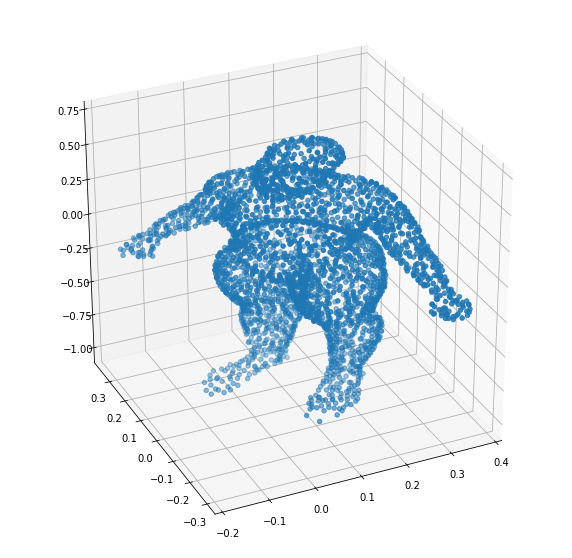

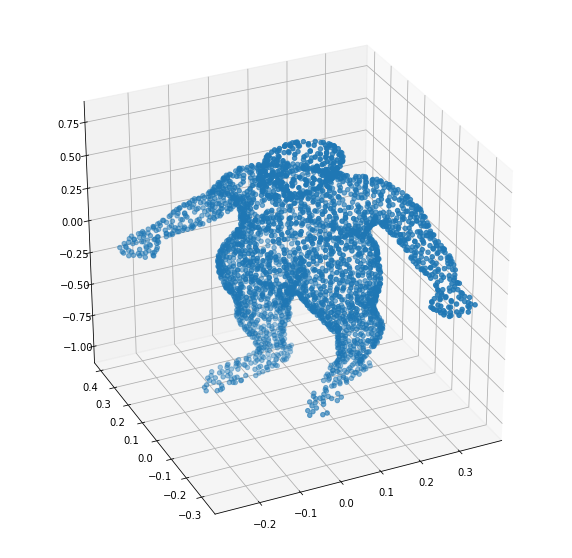

In [ ]:
female_30 = np.load('/content/drive/MyDrive/Qmind Object Completion Team/TreeGAN/female_30_sample.npy')
male_30 = np.load('/content/drive/MyDrive/Qmind Object Completion Team/TreeGAN/male_30_sample.npy')
print(female_30.shape, male_30.shape)

# code to look at the data
def plot_pointcloud(points):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    # ax.set_axis_off()
    ax.view_init(30,245) # camera view
    plt.show()

plot_pointcloud(female_30[0])
plot_pointcloud(male_30[0])


# UNIT TESTS


In [ ]:
# make an arguments instance to pass into things :)
#args = Arguments().parser().parse_args()

# Gradient Penalty unit test
def GP_UNIT_TEST():
    fake_data = np.array([1, 2, 3, 4])
    real_data = np.array([4, 6, 7, 8])
    gp = GradientPenalty(10)
    penalty = gp(lambda x: x*x, real_data, fake_data)
    print (penalty)

print("GP UNIT TEST\n\n")
GP_UNIT_TEST()

# Discriminator Unit Test
def DISC_UNIT_TEST():
    disc_boi = Discriminator(1, [3, 64, 128, 256, 512, 1024])
    pred = disc_boi(female_30)
    print(pred)

print("\n\nDISC UNIT TEST\n\n")
DISC_UNIT_TEST()

GP UNIT TEST


[<tf.Tensor: shape=(4, 1, 1, 4), dtype=float32, numpy=
array([[[[ 4.71099  ,  7.6146536,  9.614654 , 11.614654 ]]],


       [[[ 4.6443563,  7.5258083,  9.525808 , 11.525808 ]]],


       [[[ 2.0549583,  4.0732775,  6.0732775,  8.073277 ]]],


       [[[ 2.7873526,  5.0498037,  7.0498037,  9.049804 ]]]],
      dtype=float32)>]
tf.Tensor(1958.4742, shape=(), dtype=float32)


DISC UNIT TEST


vertex_dim 3072
tf.Tensor(
[[0.1260998 ]
 [0.22598279]
 [0.19648305]
 [0.15071541]
 [0.17392977]
 [0.1348284 ]
 [0.18085237]
 [0.1309391 ]
 [0.08929113]
 [0.21857262]
 [0.14353989]
 [0.09037989]
 [0.14990163]
 [0.2194007 ]
 [0.20370448]
 [0.20457736]
 [0.12607774]
 [0.12269779]
 [0.13538957]
 [0.20001942]
 [0.1857523 ]
 [0.16343945]
 [0.17204581]
 [0.15778641]
 [0.10274191]
 [0.17537197]
 [0.0602887 ]
 [0.07957587]
 [0.19216028]
 [0.16752976]], shape=(30, 1), dtype=float32)


In [ ]:
# Declare model architecture - Generator (TreeGCN), Discriminator, GradientPenalty
class TreeGAN():
  def __init__(self, args):
    self.args = args
    self.G = Generator(batch_size=args.batch_size, features=args.G_FEAT, degrees=args.DEGREES, support=args.support)
    self.D = Discriminator(batch_size=args.batch_size, features=args.D_FEAT)

    self.GP = GradientPenalty(args.lambdaGP, gamma=1)

    self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    print("Network Prepared") 

    self.visualize = visdom.Visdom(port=args.visdom_port)
    assert self.visualize.check_connection()
    print("Visdom Connected")

  def run(self, save_d_ckpt=None, save_g_ckpt=None, load_g_ckpt=None, load_d_ckpt=None): # Add arguments for whether to save/load data
    #visdom visualizations
    color_num = self.args.visdom_color
    chunk_size = int(self.args.point_num / color_num)
    #color list
    colors = np.array([(227,0,27),(231,64,28),(237,120,15),(246,176,44),
                           (252,234,0),(224,221,128),(142,188,40),(18,126,68),
                           (63,174,0),(113,169,156),(164,194,184),(51,186,216),
                           (0,152,206),(16,68,151),(57,64,139),(96,72,132),
                           (172,113,161),(202,174,199),(145,35,132),(201,47,133),
                           (229,0,123),(225,106,112),(163,38,42),(128,128,128)])
    #randomly choose color from list
    colors = colors[np.random.choice(len(colors), color_num, replace=False)]
    label = tf.stack([tf.ones(chunk_size) * inx for inx in range(1,int(color_num)+1)], axis=0).view(-1)

    # Add option to load trained model parameters
    if not load_g_ckpt == None:
      self.G.load_weights(load_g_ckpt)
      print("Generator Checkpoint Loaded")
    if not load_d_ckpt == None:
      self.D.load_weights(load_d_ckpt)
      print("Discriminator Checkpoint Loaded")

    #training loop (for one epoch)
    for epoch in range(self.args.epochs):
      for batch in range(self.args.batch_size):
        start_time = time.time()
        half_batch = int (self.args.batch_size / 2)

        # -------Discriminator------- #
        d_loss_sum = 0
        for iter in range(self.args.D_iter):
          # Generate latent vectors
          latent = np.random.randn(self.args.latent_dim * self.args.batch_size)
          latent = latent.reshape(self.args.batch_size, self.args.latent_dim)
          # Generate fake points using Generator network
          fake_point = self.G(latent)

          # Need to get real points
          real_point

          # Calculate loss on fake points (mean over a batch)
          loss_f = self.D(fake_point)
          loss_f_mean = np.mean(loss_f)
          
          # Calculate loss on real points (mean over a batch)
          loss_r = self.D(real_point)
          loss_r_mean = np.mean(loss_r)

          # Get total loss and apply gradient penalty to it
          d_loss = -loss_r_mean + loss_f_mean
          d_loss = d_loss + self.GP(self.D, real_point, fake_point)

          # Calculate gradients and backpropogate through discriminator network
          d_gradients = tf.GradientTape.gradients(d_loss, self.D.trainable_weights)
          self.D_optimizer.apply_gradients(zip(d_gradients, self.D.trainable_weights))
          
        # -------Generator-------- #
        # Create latent vector
        latent = np.random.randn(self.args.latent_dim * self.args.batch_size)
        latent = latent.reshape(self.args.batch_size, self.args.latent_dim)

        # Use latent vector to generate examples
        fake_point = self.G(latent)
        
        # Calculate mean loss using discriminator
        G_fake = self.D(fake_point)
        G_fake_mean = np.mean(G_fake)
        g_loss = -G_fake_mean

        # Apply gradients and backpropograte to train
        g_gradients = tf.GradientTape.gradients(g_loss, self.G.trainable_weights)
        self.G_optimizer.apply_gradients(zip(g_gradients, self.D.trainiable_weights))

        end_time = time.time()

        # ----- Visualization ------- #

        print("[Epoch/Iter] ", "{:3} / {:3}".format(epoch, _iter),
              "[ D_Loss ] ", "{: 7.6f}".format(d_loss), 
              "[ G_Loss ] ", "{: 7.6f}".format(g_loss), 
              "[ Time ] ", "{:4.2f}s".format(time.time()-start_time))

        if _iter % 10 == 0:
            generated_point = self.G.getPointcloud()
            plot_X = np.stack([np.arange(len(loss_log[legend])) for legend in loss_legend], 1)
            plot_Y = np.stack([np.array(loss_log[legend]) for legend in loss_legend], 1)

            self.visualize.line(X=plot_X, Y=plot_Y, win=1,
                          opts={'title': 'TreeGAN Loss', 'legend': loss_legend, 'xlabel': 'Iteration', 'ylabel': 'Loss'})

            self.visualize.scatter(X=generated_point[:,tf.convert_to_tensor([2,0,1], np.float32)], Y=label, win=2,
                              opts={'title': "Generated Pointcloud", 'markersize': 2, 'markercolor': colors, 'webgl': True})

            print('Figures are saved.')

      if epoch % self.args.save_rate == 0: #acutal number can be changed (maybe through arguments file??)
        #visualize

        # save model
        if not save_g_ckpt == None:
          self.G.save_weights(save_g_ckpt + str(epoch), save_format='tf')
          # Maybe save visualizations somehow?
        if not save_d_ckpt == None:
          self.D.save_weights(save_d_ckpt + str(epoch), save_format='tf')

        
      


SyntaxError: ignored